# **Problem 3: Conditional GAN**

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
import glob 
import pickle
from collections import defaultdict
from torchvision.datasets import MNIST

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# This chunck of code is taken from here: https://gist.github.com/y0ast/f69966e308e549f013a92dc66debeeb4
class FastMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)
        
        # Normalize it with the usual MNIST mean and std
        self.data = self.data.sub_(0.5).div_(0.5)
        
        # Put both data and targets on GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

In [ ]:
train_dataset_org = FastMNIST('data/MNIST', train=True, download=True)
test_dataset_org = FastMNIST('data/MNIST', train=False, download=True)

# check the shape of the dataset
print("shape before: ") 
print(train_dataset_org.data.shape, test_dataset_org.data.shape)
print(train_dataset_org.data.max(), train_dataset_org.data.min())

train_loader = DataLoader(train_dataset_org, batch_size=100, shuffle=True)
print(len(train_loader))
# test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False, num_workers=0)

Extracting data/MNIST/FastMNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/FastMNIST/raw


Extracting data/MNIST/FastMNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/FastMNIST/raw


Extracting data/MNIST/FastMNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/FastMNIST/raw


Extracting data/MNIST/FastMNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/FastMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


shape before: 
torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])
tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
600


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(794, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

        # dropout with probability 0.3
        self.drop = nn.Dropout(p=0.3)
    
    def forward(self, img, onehot_label):
        #flatten
        img = img.view(img.size(0), -1) #(100, 784)
        x = torch.hstack((img, onehot_label)) #(100, 794)

        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        x = self.drop(F.relu(self.fc4(x)))
        x = torch.sigmoid(self.out(x)) # (100, 1)
        return x.squeeze()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(110, 200)
        self.fc2 = nn.Linear(200, 400)
        self.fc3 = nn.Linear(400, 600)
        self.out = nn.Linear(600, 784)
    
    def forward(self, img, onehot_label):
        x = torch.hstack((img, onehot_label)) #(100, 110)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.tanh(self.out(x))
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [ ]:
batch_size=100

d = Discriminator()
g = Generator()

# print network
print(d.to(device))
print(g.to(device))

# optimizers
d_opt = optim.Adam(d.parameters(), lr=1e-4)
g_opt = optim.Adam(g.parameters(), lr=3e-4)

# loss function
err_func = nn.BCELoss()

Discriminator(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=110, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=600, bias=True)
  (out): Linear(in_features=600, out_features=784, bias=True)
)


In [ ]:
def d_trainer(d_optimizer, fake_images, fake_labels, real_images, real_labels):
    # training steps for discriminator
    d_optimizer.zero_grad()

    # train with real images
    real_predictions = d(real_images, real_labels) #(100)
    real_loss = err_func(real_predictions, torch.ones(batch_size).to(device))
    correct_real = correct_calculations(real_predictions, "real")

    # train with fake images
    fake_predictions = d(fake_images, fake_labels)
    fake_loss = err_func(fake_predictions, torch.zeros(batch_size).to(device))
    correct_fake = correct_calculations(fake_predictions, "fake")

    # calculating total loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item(), correct_real, correct_fake

def g_trainer(g_optimizer, fake_images, fake_labels):
    # training steps for Generator
    g_optimizer.zero_grad()
    
    predictions = d(fake_images, fake_labels)
    g_loss = err_func(predictions, torch.ones(batch_size).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [ ]:
def correct_calculations(predictions, check):
    temp_list = [1 if pred >= 0.5 else 0 for pred in predictions]
    temp_list = torch.Tensor(temp_list).to(device)
    labels = torch.ones(batch_size).to(device)
    correct = (temp_list == labels).sum().item()
    return correct

In [ ]:
def onehot_encoding(labels):
    if not labels.is_cuda:
        labels = labels.to(device)
    y_onehot = torch.zeros(len(labels), 10).to(device)
    y_onehot.scatter_(1, labels.reshape(-1,1), 1)
    # print(y_onehot[1], y_onehot.shape)
    return y_onehot

In [ ]:
epochs = 300
red, blue = [], []
for e in range(1, epochs+1):
    gLoss_epoch, dLoss_epoch = 0, 0
    D_real_red_corr, G_fake_blue_corr = 0, 0
    
    for real_img, real_labels in train_loader: 
        #torch.Size([100, 1, 28, 28]) torch.Size([100])

        # torch.Size([100, 10]) torch.Size([100, 100])
        onehot_real_labels = onehot_encoding(real_labels)
        noise_vector = torch.randn(batch_size, 100).to(device)

        # torch.Size([100, 10])
        fake_labels = np.array([[i] * 10 for i in range(10)]).reshape(-1)
        np.random.shuffle(fake_labels)
        onehot_fake_labels = onehot_encoding(torch.LongTensor(fake_labels))

        #torch.Size([100, 1, 28, 28])
        fake_img = g(noise_vector, onehot_fake_labels)

        # training discriminator
        # used detach to prevent gradient calculation
        # https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but
        d_loss, real_batch_corr, fake_batch_corr = d_trainer(d_opt, fake_img.detach(), onehot_fake_labels, real_img, onehot_real_labels)

        # training generator
        g_loss = g_trainer(g_opt, fake_img, onehot_fake_labels)
        
        D_real_red_corr += real_batch_corr
        G_fake_blue_corr += fake_batch_corr
       
        gLoss_epoch += g_loss
        dLoss_epoch += d_loss

    # loss calculation
    gLoss_epoch = round(gLoss_epoch/len(train_loader), 4)
    dLoss_epoch = round(dLoss_epoch/len(train_loader), 4)
    
    # accuracy calculation
    d_real_red = round(D_real_red_corr / len(train_loader.dataset), 3)
    g_fake_blue = round(G_fake_blue_corr / len(train_loader.dataset), 3)
    red.append(d_real_red)
    blue.append(g_fake_blue)
    
    if e%5 == 0:
        print("Epoch: {eps}  |  D loss: {dl}  |  G loss: {gl}   |     D acc: {da}   |   G acc: {ga}".
              format(eps=e, da=d_real_red, ga=g_fake_blue, dl=dLoss_epoch, gl=gLoss_epoch ))

Epoch: 5  |  D loss: 0.6945  |  G loss: 2.0655   |     D acc: 0.783   |   G acc: 0.073
Epoch: 10  |  D loss: 0.8774  |  G loss: 1.5555   |     D acc: 0.741   |   G acc: 0.142
Epoch: 15  |  D loss: 1.054  |  G loss: 1.2502   |     D acc: 0.674   |   G acc: 0.205
Epoch: 20  |  D loss: 1.0948  |  G loss: 1.1581   |     D acc: 0.668   |   G acc: 0.223
Epoch: 25  |  D loss: 1.2363  |  G loss: 0.9193   |     D acc: 0.579   |   G acc: 0.274
Epoch: 30  |  D loss: 1.2508  |  G loss: 0.9271   |     D acc: 0.594   |   G acc: 0.297
Epoch: 35  |  D loss: 1.2866  |  G loss: 0.8612   |     D acc: 0.58   |   G acc: 0.333
Epoch: 40  |  D loss: 1.283  |  G loss: 0.8593   |     D acc: 0.594   |   G acc: 0.336
Epoch: 45  |  D loss: 1.3147  |  G loss: 0.7973   |     D acc: 0.565   |   G acc: 0.35
Epoch: 50  |  D loss: 1.317  |  G loss: 0.8169   |     D acc: 0.56   |   G acc: 0.344
Epoch: 55  |  D loss: 1.3111  |  G loss: 0.8049   |     D acc: 0.567   |   G acc: 0.349
Epoch: 60  |  D loss: 1.325  |  G loss:

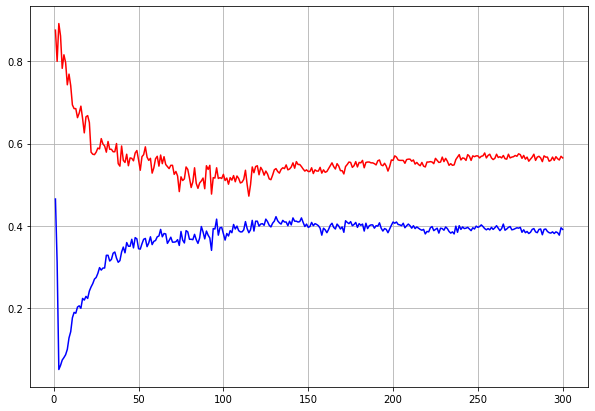

In [ ]:
# convergence graph
fig = plt.figure(figsize=(10, 7))
epochs = np.arange(1, 301, 1)
plt.plot(epochs, red, color='red', label="accuracy on real")
plt.plot(epochs, blue, color='blue', label="accuracy on fake")
plt.grid()
plt.show()

In [ ]:
g.eval()
with torch.no_grad():
    noise = torch.randn(batch_size, 100).to(device)
    fake_labels = np.array([[l] * 10 for l in range(10)]).reshape(-1)
    fake_labels = onehot_encoding(torch.LongTensor(fake_labels))
    generated_data = g(noise, fake_labels)

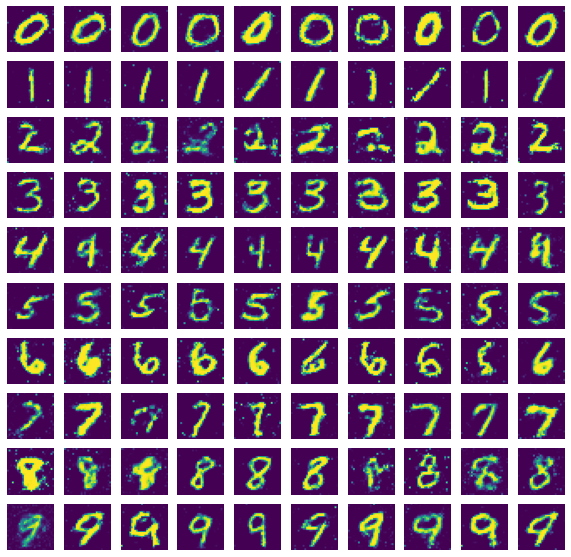

In [ ]:
# final results
fig,axes = plt.subplots(nrows = 10, ncols = 10, figsize=(10,10))
i = 0
for n in range(10):
    for j in range(10):
        axes[n, j].imshow(torch.squeeze(generated_data[i]).cpu().numpy())
        axes[n, j].axis('off')
        i += 1
fig.show()